In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import scipy

# import numba

In [2]:
from IPython.display import Audio, display

url_exception = "http://www.wav-sounds.com/movie/austinpowers.wav"
url_exception = "https://www.myinstants.com/media/sounds/roblox-death-sound_1.mp3"


def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio(url=url_exception, autoplay=True))


get_ipython().set_custom_exc((Exception,), play_sound)

url_done = (
    "https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav"
)
url_done = "https://www.myinstants.com/media/sounds/taco-bell-bong-sfx.mp3"
url_done = "https://www.myinstants.com/media/sounds/magic_immune.mp3"
# url_done="https://www.myinstants.com/media/sounds/tindeck_1.mp3"
# url_done="https://www.myinstants.com/media/sounds/dun_dun_1.mp3"


def allDone():
    display(Audio(url=url_done, autoplay=True,))

In [3]:
data_dir = os.path.join(os.getcwd(), "data")
drone_dir = os.path.join(data_dir, "tir_pavel")

In [4]:
video0 = np.load(os.path.join(drone_dir, "pavel0.npy"))
print(video0.shape)

(1144, 436, 496)


In [5]:
import datetime as dt

timestamp0 = np.load(os.path.join(drone_dir, "timestamp0.npy")).squeeze()
print(video0.shape)


def md(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=matlab_datenum % 1) - dt.timedelta(days=366)
    return pd.Timestamp(day + dayfrac).round("S")


matlab_to_date = np.vectorize(md)
timestamp0 = matlab_to_date(timestamp0)

(1144, 436, 496)


In [6]:
video0_df = pd.DataFrame({"frame": [*video0]})
video0_df.index = timestamp0
video0_df

frame
2019-08-06 12:29:34  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
2019-08-06 12:29:35  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
2019-08-06 12:29:36  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
2019-08-06 12:29:37  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
2019-08-06 12:29:38  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
...                                                                ...
2019-08-06 12:48:33  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
2019-08-06 12:48:34  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
2019-08-06 12:48:35  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
2019-08-06 12:48:36  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
2019-08-06 12:48:37  [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...

[1144 rows x 1 columns]

#### merging the two:

making the data more coarse: 
* https://stackoverflow.com/a/39952846/6293070
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html 
* we probably want to resample down to half seconds? and take that average?

merging the two:
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html#pandas.merge_asof
* https://stackoverflow.com/a/43979285/6293070
    

In [7]:
label_df_1 = pd.read_hdf(os.path.join(drone_dir, "pavel_label_1"), "/df")
label_df_2 = pd.read_hdf(os.path.join(drone_dir, "pavel_label_2"), "/df")
label_df = pd.concat([label_df_1, label_df_2], axis=0)
print(label_df.shape)

ImportError: Missing optional dependency 'tables'.  Use pip or conda to install tables.

In [ ]:
label_df = label_df.resample("1S").median()
print(label_df.shape)

In [ ]:
print(pd.Timedelta("5S"))
print(pd.Timedelta("500L"))

In [ ]:
video0_df_w_labels = pd.merge_asof(
    video0_df,
    label_df,
    left_index=True,
    right_index=True,
    tolerance=pd.Timedelta("3S"),
    direction="nearest",
)

print(video0_df_w_labels.shape)
print(video0_df_w_labels.head(10))

In [ ]:
any(video0_df_w_labels[23] == video0_df_w_labels[23].shift(1))

Somehow take the center of this:

for now just take width and height from shape
divide it by four

then take the middle half

In [8]:
# might not be the right order!


def get_middle(a):
    video0 = a
    frames, height, width = video0.shape

    cut_off = 4

    left = width // cut_off
    right = width - left
    top = height // cut_off
    bottom = height - top

    video0 = video0[:, top:bottom, left:right]
    return video0

In [9]:
def replace_nan_with_mean(a):
    return np.where(np.isnan(a), np.ones_like(a) * np.nanmean(a), a)

detrending:
* take 30 seconds of video
* wow so detrend...
* for every frame find median value
* everything above median is white (1), everything below is black(0)

(1144, 436, 496)
(1143, 109, 124)
2.0855284003887427
-2.0855284003887427
0.8473718624674956
0.005706977834214867


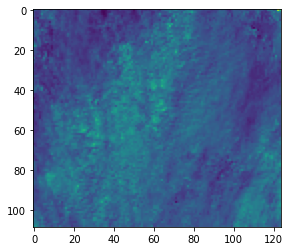

In [70]:
from scipy import signal
from functools import partial

video = np.load(os.path.join(drone_dir, "pavel0.npy"))
print(video.shape)



def get_frame_middle(frame, cut_off):
    a = frame
    height, width = a.shape

    left = width // cut_off
    right = width - left
    top = height // cut_off
    bottom = height - top

    return a[top:bottom, left:right]


def median_mask(b, n_dev):
    a = b
    std = np.std(a) * n_dev
    median = np.median(a)
    a[a < median - std] = median - std
    a[a >= median + std] = median + std
    return a


def moving_average(video, window_size):
    secs = np.arange(1, video.shape[0])
    mavgl = []
    for i in secs:
        if i >= window_size:
            mavgl.append(np.nanmean(video[i - window_size : i, :, :], axis=0))
        else:
            mavgl.append(np.nanmean(video[:i, :, :], axis=0))
    return np.stack(mavgl, axis=0)


# @numba.jit(nopython=True)
def sigmoid(a):
    return 1 / (1 + np.exp(-a))


def subtract_median(a):
    return a - np.median(a)


def subtract_from_frame(a, sub):
    return a - sub

def divide_by_std(a):
    return a / a.std()


def apply_to_outer_axis(a, func, args=[]):
    b = a
    for i in range(b.shape[0]):
        b[i] = func(b[i], *args)
    return b


def apply_funcs_to_outer_axis(a, funcs):
    """
    args:
    a: thing to apply over
    funcs: list of functions to apply over, can take args
        for example:
            funcs = [f_a, f_b]
            funcs = [(f_a, [1,2,3]), (f_b, [1])]
        a functions with args should be a pair with the args as a list
    """
    for i, f in enumerate(funcs):
        if callable(f):
            funcs[i] = (f, [])

    b = []
    for i in range(a.shape[0]):
        b.append(a[i])
        for f, args in funcs:
            b[i] = f(b[i], *args)
    return np.stack(b, axis=0)


# video = apply_to_outer_axis(video, median_mask)
# video = apply_funcs_to_outer_axis(
#     video, [(get_frame_middle, [4]), subtract_median, sigmoid]
# )
video = replace_nan_with_mean(video)

video = get_middle(video)

video = (video - np.median(video)) / video.std()

video = scipy.signal.detrend(video, axis=0)
video = moving_average(video, 3)
video = apply_to_outer_axis(video, subtract_median)
video = apply_to_outer_axis(video, np.tanh)
video = apply_to_outer_axis(video, median_mask, [2])
video = apply_to_outer_axis(video, divide_by_std)
from skimage.transform import rescale
b = []
for i in range(video.shape[0]):
    b.append(rescale(video[i], 0.5, anti_aliasing=False))
video = np.stack(b, axis=0)


# video = replace_nan_with_mean(video)
# video = apply_funcs_to_outer_axis(video, [subtract_median, (subtract_from_frame, [1])])
# video = scipy.signal.detrend(video, axis=0, bp=range(0, video.shape[0], 30))
# video = scipy.signal.detrend(video, axis=0, bp=range(0, video.shape[0], 480))

# from scipy import signal

# sos = signal.ellip(4, 5, 40, 0.45, output="sos", fs=1)
# video = signal.sosfilt(sos, video)



# video = apply_funcs_to_outer_axis(video, [(rescale, [0.25, False])])



# video = video[:, ::4, ::4]

# video = video[400:500]

print(video.shape)
# print(video_boi)
print(video[0].max())
print(video[0].min())
print(video[0].std())
print(video[0].mean())
# for frame in video:
#     print(frame.std())

import matplotlib.pyplot as plt
plt.imshow(np.mean(video, axis=0))

# sucessfull video pre-processing stacks
* subtract_median, sigmoid, detrend_all, median_mask
* subtract_median, sigmoid, detrend_all, median_mask(2nd dev)

In [71]:
def Tensor_to_video(Tensor, path):
    Tensor = tf.where(
        tf.math.is_nan(Tensor),
        tf.ones_like(Tensor) * np.nanmean(Tensor.numpy()),
        Tensor,
    )
    video = tf.cast(255 * min_max_norm(Tensor), tf.uint8)
    frames, width, height = video.shape
    _fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    out = cv2.VideoWriter(path, _fourcc, 10, (width, height))
    for i in range(frames):
        img = video[i, :, :]
        img = tf.repeat(tf.expand_dims(tf.transpose(img), axis=-1), 3, axis=2).numpy()
        out.write(img)


def min_max_norm(Tensor):
    min = tf.reduce_min(Tensor)
    max = tf.reduce_max(Tensor)
    return (Tensor - min) / (max - min)


video_path = os.path.join(data_dir, "videos", "center_video.mp4")
Tensor_to_video(tf.convert_to_tensor(video), video_path)

from IPython.display import Video

video_path = os.path.join(data_dir, "videos", "center_video.mp4")
Video(video_path, embed=True)

# things to try:
* how much to downsample?
* does our pre-processing do anything?
<!-- * do we need the whole image -->